In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_val, y_train, y_val = mnist_prep()

In [5]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

# EnKF

In [6]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [7]:
batch_size = 50     # len(X_train)
epochs = 10
particles = 50
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [8]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [9]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [10]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [11]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [12]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [13]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 976us/step - loss: 2.3061 - accuracy: 0.0860


In [14]:
import time
start_time = time.time()

In [15]:
# loop over all epochs
for epoch in range(epochs):
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)  
        
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    print("Training Accuracy after Epoch {}: {}".format(str(epoch+1), str(np.round(mean_model_train_acc[-1], 3))))

Training Accuracy after Epoch 1: 0.111
Training Accuracy after Epoch 2: 0.204
Training Accuracy after Epoch 3: 0.209
Training Accuracy after Epoch 4: 0.226
Training Accuracy after Epoch 5: 0.229
Training Accuracy after Epoch 6: 0.246
Training Accuracy after Epoch 7: 0.256
Training Accuracy after Epoch 8: 0.26
Training Accuracy after Epoch 9: 0.269
Training Accuracy after Epoch 10: 0.27


In [16]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 5.86415513753891 minutes.


In [17]:
y_pred_dict["model_1"]

array([[1.33698747e-01, 4.59037609e-02, 1.40406042e-01, 1.13052420e-01,
        4.65794951e-02, 1.09171651e-01, 1.00638472e-01, 1.71471313e-01,
        9.37794968e-02, 4.52985168e-02],
       [2.19777405e-01, 3.73103023e-02, 9.94951576e-02, 5.01322597e-02,
        1.29297256e-01, 1.00282915e-01, 6.56165630e-02, 7.15158284e-02,
        9.96475667e-02, 1.26924768e-01],
       [3.39965433e-01, 1.74197294e-02, 1.20142072e-01, 6.34732470e-02,
        2.29615450e-01, 7.67016709e-02, 7.84815103e-02, 1.29561648e-02,
        5.93546480e-02, 1.89011393e-03],
       [1.29086196e-01, 4.73131277e-02, 8.73118266e-02, 4.58258539e-02,
        1.27577707e-01, 2.28746697e-01, 4.24061418e-02, 1.43865675e-01,
        6.37932047e-02, 8.40735212e-02],
       [1.17048778e-01, 1.14758071e-02, 1.54428750e-01, 3.14619452e-01,
        5.11248857e-02, 1.00583471e-01, 1.49904698e-01, 4.39557992e-02,
        4.45979349e-02, 1.22604333e-02],
       [1.40553772e-01, 5.90065159e-02, 9.74595994e-02, 3.22762318e-02,
   

In [18]:
jacobian_dict["model_1"]

array([[ -0.       , -19.644915 ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -7.446169 ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -7.990918 ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -4.2781353,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -6.2723947,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       , -16.601759 ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       ,  -0.       ,  -0.       ,
         -0.       ,  -0.       ,  -0.       

In [19]:
print(np.round(mean_model_train_acc, 3))
print(np.round(mean_model_test_acc, 3))

[0.094 0.111 0.204 0.209 0.226 0.229 0.246 0.256 0.26  0.269 0.27 ]
[0.086 0.112 0.16  0.162 0.182 0.198 0.2   0.212 0.21  0.206 0.21 ]


In [20]:
train_acc_dict

{'model_1': [0.1420000046491623,
  0.19200000166893005,
  0.20600000023841858,
  0.21299999952316284,
  0.22200000286102295,
  0.23499999940395355,
  0.24799999594688416,
  0.25699999928474426,
  0.26600000262260437,
  0.27000001072883606],
 'model_2': [0.15000000596046448,
  0.19300000369548798,
  0.20999999344348907,
  0.22200000286102295,
  0.22699999809265137,
  0.23800000548362732,
  0.25099998712539673,
  0.2590000033378601,
  0.2639999985694885,
  0.2680000066757202],
 'model_3': [0.10999999940395355,
  0.17800000309944153,
  0.21199999749660492,
  0.22100000083446503,
  0.23199999332427979,
  0.24500000476837158,
  0.2590000033378601,
  0.26600000262260437,
  0.27300000190734863,
  0.27399998903274536],
 'model_4': [0.12399999797344208,
  0.20900000631809235,
  0.21799999475479126,
  0.2280000001192093,
  0.23100000619888306,
  0.24799999594688416,
  0.2549999952316284,
  0.25999999046325684,
  0.26899999380111694,
  0.26899999380111694],
 'model_5': [0.09700000286102295,
  0.1

In [21]:
test_acc_dict

{'model_1': [0.1420000046491623,
  0.17000000178813934,
  0.16599999368190765,
  0.17800000309944153,
  0.18400000035762787,
  0.1979999989271164,
  0.20600000023841858,
  0.21199999749660492,
  0.20999999344348907,
  0.20999999344348907],
 'model_2': [0.11599999666213989,
  0.1679999977350235,
  0.1720000058412552,
  0.18199999630451202,
  0.1899999976158142,
  0.20800000429153442,
  0.21199999749660492,
  0.20600000023841858,
  0.20800000429153442,
  0.20399999618530273],
 'model_3': [0.1080000028014183,
  0.15399999916553497,
  0.1720000058412552,
  0.17800000309944153,
  0.1899999976158142,
  0.20000000298023224,
  0.20999999344348907,
  0.21199999749660492,
  0.21199999749660492,
  0.20600000023841858],
 'model_4': [0.10199999809265137,
  0.17800000309944153,
  0.17000000178813934,
  0.1860000044107437,
  0.19599999487400055,
  0.20000000298023224,
  0.21199999749660492,
  0.20600000023841858,
  0.20800000429153442,
  0.20999999344348907],
 'model_5': [0.09000000357627869,
  0.150

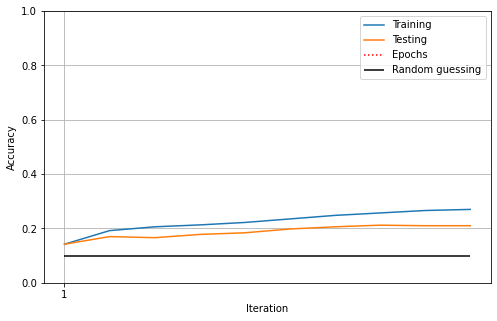

In [22]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

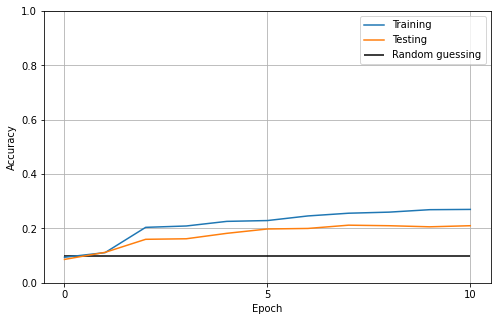

In [23]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = True,
                  file = "../img/enkf_model_mnist_E{}_B{}_P{}_H{}.png".format(epochs, batch_size, particles, h_0))

In [24]:
nn_save(mean_model, 
        "../models/enkf_model_mnist_E{}_B{}_P{}_H{}.h5".format(epochs, batch_size, particles, h_0))